[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading pest text data (reversed order)...
Successfully loaded data for 8 pest species (reversed order).

Generating fixed reversed side-by-side charts...


C:\Users\35088\AppData\Local\Temp\ipykernel_34996\1251321525.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax_left.boxplot(
C:\Users\35088\AppData\Local\Temp\ipykernel_34996\1251321525.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_xticklabels(ax_left.get_xticklabels(), fontsize=14)
C:\Users\35088\AppData\Local\Temp\ipykernel_34996\1251321525.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_yticklabels(valid_class_names, fontsize=14)
C:\Users\35088\AppData\Local\Temp\ipykernel_34996\1251321525.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_x

Fixed reversed charts saved to side_by_side_pest_charts_reversed_fixed.png


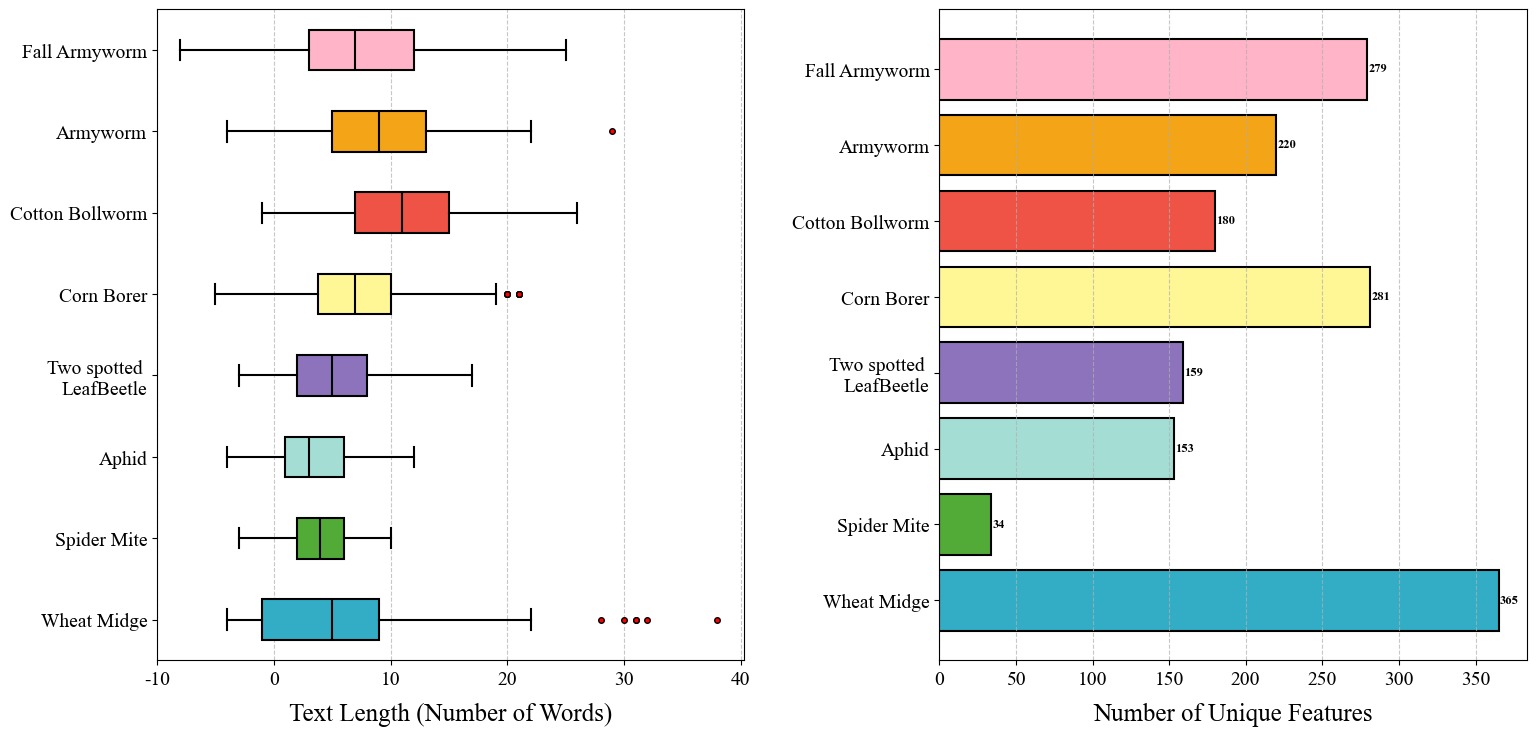

In [1]:
import os
import json
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ----------------------
# 1. 全局样式配置（保持原风格）
# ----------------------
plt.style.use('seaborn-v0_8-muted')
plt.rcParams["font.family"] = ["Times New Roman", "Arial"]
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.titlesize'] = 14

# 自定义颜色（保持不变）
custom_colors_rgb = [
    (255, 180, 200),
    (243, 164, 23),
    (238, 83, 70),
    (255, 247, 150),
    (141, 115, 188),
    (164, 221, 212),
    (83, 171, 55),
    (50, 173, 197)  
]
custom_colors_rgb = reversed(custom_colors_rgb)

custom_colors = [(r/255, g/255, b/255) for r, g, b in custom_colors_rgb]

# custom_colors = reversed(custom_colors)

# 原始8种害虫名称（先定义原始顺序，便于后续反转）
original_class_names = [
    'Fall Armyworm',
    'Armyworm',
    'Cotton Bollworm',
    'Corn Borer',
    'Two spotted \nLeafBeetle',
    'Aphid',
    'Spider Mite',
    'Wheat Midge'
]
# 反转后的害虫名称（标签顺序反转）
class_names = original_class_names[::-1]

# 下载NLTK资源
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# ----------------------
# 2. 数据加载与预处理（关键修复：子文件夹也反转顺序）
# ----------------------
def load_pest_text_data(main_folder):
    pest_data = {}
    # 关键修改1：子文件夹列表反转，与反转后的class_names对应
    subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
    reversed_subfolders = subfolders[:8][::-1]  # 取前8个子文件夹并反转顺序
    
    # 现在：反转后的class_names 对应 反转后的子文件夹（数据完全匹配）
    for idx, (pest_name, subfolder) in enumerate(zip(class_names, reversed_subfolders)):
        pest_folder = os.path.join(main_folder, subfolder)
        text_lengths = []
        all_filtered_tokens = set()
        
        for filename in os.listdir(pest_folder):
            if filename.endswith(('.txt', '.json')):
                file_path = os.path.join(pest_folder, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        content = re.sub(r',\s*}', '}', content)
                        data = json.loads(content)
                    
                    pest_num = 1
                    while True:
                        pest_key = f'pest {pest_num}'
                        if pest_key not in data:
                            break
                        charac_en = data[pest_key].get('The Characteristics of pest EN', '').strip()
                        if charac_en:
                            processed_text = charac_en.lower().translate(str.maketrans('', '', string.punctuation))
                            tokens = word_tokenize(processed_text)
                            filtered_tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
                            if filtered_tokens:
                                text_lengths.append(len(filtered_tokens))
                                all_filtered_tokens.update(filtered_tokens)
                        pest_num += 1
                except Exception as e:
                    print(f"Warning: Failed to process {filename} - {str(e)}")
        
        pest_data[pest_name] = {
            'text_lengths': text_lengths,
            'feature_count': len(all_filtered_tokens),
            'feature': all_filtered_tokens
        }
    return pest_data


def remove_outliers(data):
    if len(data) < 4:
        return data
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]


# ----------------------
# 3. 核心图表绘制（数据和标签已同步反转）
# ----------------------
def plot_side_by_side_charts(pest_data, output_path='side_by_side_pest_charts_reversed_fixed.png'):
    box_data = []
    feature_counts = []
    valid_class_names = []
    
    # 按反转后的class_names循环，数据顺序同步反转
    for name in class_names:
        lengths = pest_data[name]['text_lengths']
        if not lengths:
            continue
        lengths_no_outliers = remove_outliers(lengths)
        if lengths_no_outliers:
            box_data.append(lengths_no_outliers)
            feature_counts.append(pest_data[name]['feature_count'])
            valid_class_names.append(name)
    
    # 创建子图
    fig, (ax_left, ax_right) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(16, 8),
        sharey=False
    )

    # 左图：箱线图（数据+标签均反转）
    box_plot = ax_left.boxplot(
        box_data,
        patch_artist=True,
        labels=valid_class_names,
        boxprops=dict(linewidth=1.5),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5),
        medianprops=dict(linewidth=1.5, color='black'),
        flierprops=dict(marker='o', markerfacecolor='red', markersize=4),
        vert=False
    )
    for patch, color in zip(box_plot['boxes'], custom_colors[:len(valid_class_names)]):
        patch.set_facecolor(color)
    ax_left.set_xlabel('Text Length (Number of Words)', labelpad=10, fontsize=18)
    ax_left.set_yticklabels(valid_class_names, fontsize=14)
    ax_left.set_xticklabels(ax_left.get_xticklabels(), fontsize=14)
    # ax_left.set_ylabel('Pest Species', labelpad=10)
    # ax_left.set_title('(a) Text Description Length Distribution (Reversed Order)', y=-0.2)
    ax_left.grid(axis='x', linestyle='--', alpha=0.7)
    ax_left.set_xlim(left=0)

    # 右图：条形图（数据+标签均反转）
    bars = ax_right.barh(
        valid_class_names,
        feature_counts,
        color=custom_colors[:len(valid_class_names)],
        edgecolor='black',
        linewidth=1.5
    )
    for bar, count in zip(bars, feature_counts):
        width = bar.get_width()
        ax_right.text(
            width + 1,
            bar.get_y() + bar.get_height()/2.,
            str(count),
            ha='left',
            va='center',
            fontsize=9,
            fontweight='bold'
        )
    ax_right.set_xlabel('Number of Unique Features', labelpad=10, fontsize=18)
    ax_right.set_yticklabels(valid_class_names, fontsize=14)
    ax_right.set_xticklabels(ax_right.get_xticklabels(), fontsize=14)
    # ax_right.set_ylabel('Pest Species', labelpad=10)
    # ax_right.set_title('(b) Number of Unique Features (Reversed Order)', y=-0.2)
    ax_right.grid(axis='x', linestyle='--', alpha=0.7)
    ax_right.set_xlim(left=0)

    # 布局优化
    plt.tight_layout(pad=3.0)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Fixed reversed charts saved to {output_path}")
    plt.show()

    fig.savefig('Fig_8_Analysis of Text Feature Statistics_Reversed_Fixed.pdf', bbox_inches='tight')


# ----------------------
# 4. 主函数（不变）
# ----------------------
if __name__ == "__main__":
    main_data_path = r'D:\25.10.29backup\25.7.24\pest_text\api\data\caption_en'
    
    print("Loading pest text data (reversed order)...")
    pest_data = load_pest_text_data(main_data_path)
    if not any([pest_data[name]['text_lengths'] for name in class_names]):
        print("Error: No valid text data loaded! Please check the folder path.")
        exit()
    print(f"Successfully loaded data for {sum(1 for name in class_names if pest_data[name]['text_lengths'])} pest species (reversed order).")
    
    print("\nGenerating fixed reversed side-by-side charts...")
    plot_side_by_side_charts(pest_data)

In [4]:
pest_data['Spider Mite']['feature']

{'almost',
 'back',
 'bent',
 'blackishbrown',
 'body',
 'brown',
 'color',
 'covered',
 'dark',
 'downward',
 'downwardcurved',
 'equal',
 'feet',
 'first',
 'four',
 'fourth',
 'grooves',
 'hairs',
 'legs',
 'length',
 'long',
 'longest',
 'mouthparts',
 'oval',
 'pair',
 'pairs',
 'red',
 'second',
 'sparsely',
 'striae',
 'striations',
 'third',
 'transverse',
 'white'}